# Variational Autoencoder (VAE) with PyTorch

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from typing import Tuple
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

## Encoder

In [2]:
class Encoder(nn.Module):
    def __init__(self, latent_dim: int):
        super().__init__()
        
        # Feature extractor
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
        )
        
        # Fully connected layers for mean and log variance
        self.fc1 = nn.Linear(64*7*7, 400)  # 7x7 Feature map after pooling
        self.fc2_mean = nn.Linear(400, latent_dim)
        self.fc2_logvar = nn.Linear(400, latent_dim)
    
    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        # Feature extraction
        x = self.feature_extractor(x)

        # Mean and log variance computation
        x = F.relu(self.fc1(x))
        mean = self.fc2_mean(x)
        logvar = self.fc2_logvar(x)
        return mean, logvar

## Decoder

In [3]:
class Decoder(nn.Module):
    def __init__(self, latent_dim: int):
        super().__init__()
        
        # Fully connected layer to reshape latent vector
        self.fc = nn.Sequential(
            nn.Linear(latent_dim, 64*7*7),
            nn.ReLU(),
        )
        
        # Transposed convolutional layers to reconstruct the image
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid(),  # ピクセル値を [0, 1] にする
        )
    
    def forward(self, z: torch.Tensor) -> torch.Tensor:
        # Latent vector
        z = self.fc(z)

        # Reshape latent vector to match the input shape of the decoder
        z = z.view(z.size(0), 64, 7, 7)

        # Reconstruct the image from the latent vector
        x_recon = self.decoder(z)
        return x_recon

## VAE Model and Loss Function

In [4]:
class VAE(nn.Module):
    def __init__(self, latent_dim: int):
        super().__init__()
        
        # Encoder and Decoder instances
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)
        
    def reparameterize(self, mu: torch.Tensor, logvar: torch.Tensor) -> torch.Tensor:
        # Reparameterization trick
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x: torch.Tensor) -> tuple:
        # Encode the input image to get mean and log variance
        mu, logvar = self.encoder(x)
        
        # Reparameterization trick to sample from the latent space
        z = self.reparameterize(mu, logvar)
        
        # Decode the latent vector to reconstruct the image
        x_reconstructed = self.decoder(z)
        
        return x_reconstructed, mu, logvar
    

def loss_function(recon_x, x, mu, logvar):
    # Reconstruction loss
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')

    # Kullback-Leibler divergence loss
    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    # Average the losses over the batch
    batch_size = x.size(0)
    return (recon_loss + kld_loss)/batch_size

## VAE Training

In [5]:
# Device configuration
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'
print('Using {} device'.format(device))
device = torch.device(device)

# MNIST dataset loading
transform = transforms.ToTensor()
train_dataset = datasets.MNIST(
    root='./data', 
    train=True,
    transform=transform,
    download=True)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# VAE model definition
model = VAE(latent_dim=2).to(device)
model.train()

# Optimizer definition
optimizer = optim.AdamW(model.parameters(), lr=1.0e-3)

# Training loop
for epoch in range(100):
    train_loss = 0

    # Iterate over the training dataset
    for batch_idx, (data, _) in enumerate(train_loader):
        # Transfer data to device (labels are not used)
        data = data.to(device)
        
        # Feedforward
        recon_batch, mu, logvar = model(data)
        
        # Calculate loss and backpropagate
        optimizer.zero_grad()
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        optimizer.step()

        # Accumulate training loss
        train_loss += loss.item()

    average_loss = train_loss / len(train_loader.dataset)
    print('Epoch: {} Average loss: {:.4f}'.format(epoch, average_loss))

# Save the trained model
model_path = './vae_model.pth'
torch.save(model.state_dict(), model_path)

Using cuda device
Epoch: 0 Average loss: 1.5018
Epoch: 1 Average loss: 1.2833
Epoch: 2 Average loss: 1.2340
Epoch: 3 Average loss: 1.2078
Epoch: 4 Average loss: 1.1919
Epoch: 5 Average loss: 1.1809
Epoch: 6 Average loss: 1.1728
Epoch: 7 Average loss: 1.1655
Epoch: 8 Average loss: 1.1597
Epoch: 9 Average loss: 1.1543
Epoch: 10 Average loss: 1.1513
Epoch: 11 Average loss: 1.1479
Epoch: 12 Average loss: 1.1442
Epoch: 13 Average loss: 1.1419
Epoch: 14 Average loss: 1.1394
Epoch: 15 Average loss: 1.1376
Epoch: 16 Average loss: 1.1356
Epoch: 17 Average loss: 1.1350
Epoch: 18 Average loss: 1.1311
Epoch: 19 Average loss: 1.1297
Epoch: 20 Average loss: 1.1293
Epoch: 21 Average loss: 1.1277
Epoch: 22 Average loss: 1.1263
Epoch: 23 Average loss: 1.1266
Epoch: 24 Average loss: 1.1260
Epoch: 25 Average loss: 1.1233
Epoch: 26 Average loss: 1.1240
Epoch: 27 Average loss: 1.1221
Epoch: 28 Average loss: 1.1209
Epoch: 29 Average loss: 1.1187
Epoch: 30 Average loss: 1.1186
Epoch: 31 Average loss: 1.1187


## Random Image Generation with VAE

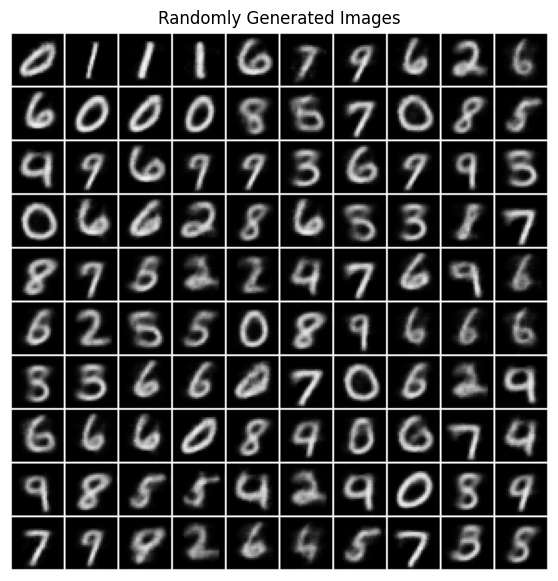

In [6]:
# Create a new VAE instance and load the saved weights
latent_dim = 2
model = VAE(latent_dim)
model.load_state_dict(torch.load('./vae_model.pth'))
model.eval()


# Generate random latent vectors and decode them to images
num_samples = 100
torch.manual_seed(42)
z = torch.randn(num_samples, latent_dim)

with torch.no_grad():
    images = model.decoder(z)


# Visualize the generated images
grid = make_grid(images, nrow=10, padding=1, pad_value=1)
grid = grid.permute(1, 2, 0)

plt.figure(figsize=(7, 7))
plt.imshow(grid)
plt.axis('off')
plt.title('Randomly Generated Images')
plt.show()

## Explore 2D Latent Space

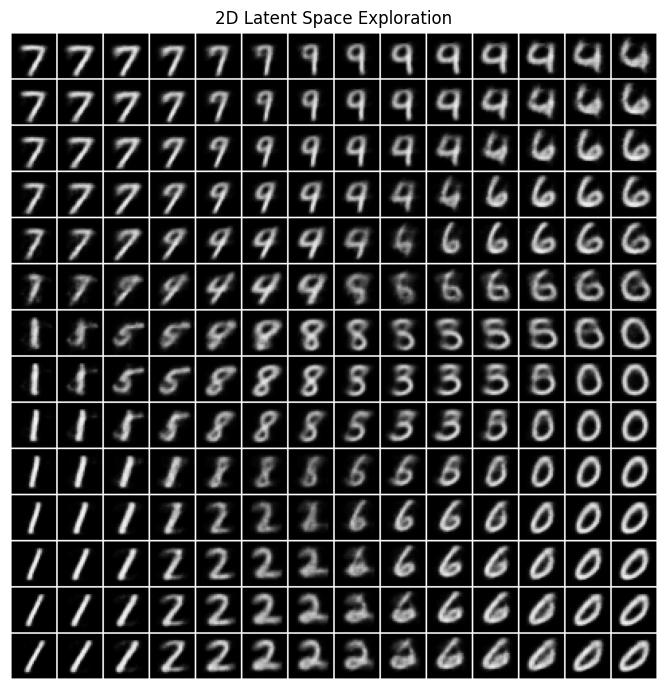

In [7]:
# Explore 2D Latent Space
latent_dim = 2

model = VAE(latent_dim)
model.load_state_dict(torch.load('./vae_model.pth'))
model.eval()


# 2D Latent Space Exploration
steps = 14
latent_values = torch.linspace(-1.5, 1.5, steps)
grid_z = torch.tensor([[z1, z2] for z1 in latent_values for z2 in latent_values])

with torch.no_grad():
    images = model.decoder(grid_z)


# Create a grid of images from the latent space exploration
grid = make_grid(images, nrow=steps, padding=1, pad_value=1)
grid = grid.permute(1, 2, 0)

plt.figure(figsize=(7, 7))
plt.imshow(grid)
plt.axis('off')
plt.title('2D Latent Space Exploration')
plt.tight_layout()
plt.show()